In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
rng = np.random.default_rng()

In [8]:
def generar_particiones(filename, n, p_test):
    ds = np.genfromtxt(filename, delimiter=',')
    n_test = int(ds.shape[0] * p_test)
    n_train = ds.shape[0] - n_test
    M_test = np.zeros((n,n_test),dtype = int)
    M_train = np.zeros((n, n_train),dtype = int)

    for i in range(n):
        idx=np.random.choice(range(ds.shape[0]),ds.shape[0],replace = False)
        idx_test = idx[0:n_test]
        idx_train = idx[n_test:ds.shape[0]]
        M_test[i] = idx_test
        M_train[i] = idx_train
    
    return (ds, M_test, M_train)

In [9]:
def som_train (X,som,nCols,nRows,actRatio,learningRate,som_history):
    for n_patetern,pattern in enumerate(X):
        
        #búsqueda de la neurona ganadora
        actN = np.argmin(np.linalg.norm(pattern - som, 1, axis = 1))

        #buscar en qué fila cae la neurona
        idxRow = 0; cRow = 0
        for i in range(0, len(som), nCols):
            if actN in range(i, i+nCols):
                idxRow = cRow
                break
            else:
                cRow += 1

        # Adaptación de pesos
        # wj(n) + η(n) (x(n) − wj(n)) de radio de vecindad

        # en la fila de la neurona activa
        # print('neuronas activadas:')
        minIdx = idxRow*nCols
        maxIdx = idxRow*nCols + nCols
        som[np.clip(actN - actRatio, minIdx, maxIdx) : np.clip(actN + actRatio + 1, minIdx, maxIdx)] = \
            som[np.clip(actN - actRatio, minIdx, maxIdx) : np.clip(actN + actRatio + 1, minIdx, maxIdx)] + \
                learningRate * (pattern - som[np.clip(actN - actRatio, minIdx, maxIdx) : np.clip(actN + actRatio + 1, minIdx, maxIdx)])
        # print(f'fila 0, ({np.clip(actN - actRatio, idxRow*nCols, idxRow*nCols +nCols)}:{np.clip(actN + actRatio + 1, idxRow*nCols, idxRow*nCols + nCols)}]')

        # en las filas hacia arriba y abajo de la neurona activa
        for i in range(1, actRatio + 1):
            # si la fila anterior existe, su índice no es negativo
            if idxRow - i > -1:
                
                minIdx = (idxRow - i) * nCols
                maxIdx = (idxRow - i) * nCols + nCols
                # print(f'rango de indices: {minIdx}-{maxIdx}')
                # clampeo los valores para que se encuentren dentro del rango de índices de la fila
                idxIni = np.clip(actN - (i * nCols) - (actRatio - i), minIdx, maxIdx)
                idxFin = np.clip(actN - (i * nCols) + (actRatio - i) + 1, minIdx, maxIdx)
                # print(f'fila - {i}, ({idxIni}:{idxFin}]')
                # actualizo los pesos de la neurona
                som[idxIni : idxFin] = som[idxIni : idxFin] + learningRate * (pattern - som[idxIni : idxFin])
                # si la fila a siguiente existe, el índice es menor que la cantidad de cols del mapa
            if idxRow + i < nRows:
                minIdx = (idxRow + i) * nCols
                maxIdx = (idxRow + i) * nCols + nCols
                # print(f'rango de indices: {minIdx}-{maxIdx}')
                # clampeo los valores para que se encuentren dentro del rango de índices de la fila
                idxIni = np.clip(actN + (i * nCols) - (actRatio - i), minIdx, maxIdx)
                idxFin = np.clip(actN + (i * nCols) + (actRatio - i) + 1, minIdx, maxIdx)
                # print(f'fila + {i}, ({actN + (i * nCols) - (actRatio - i)}:{actN + (i * nCols) + (actRatio - i) + 1}]')
                som[idxIni : idxFin] = som[idxIni : idxFin] + learningRate * (pattern - som[idxIni : idxFin])
    som_history.append(som.copy())
    return som_history

In [10]:
ds, testPartitionsIdx, trainPartitionsIdx  =  generar_particiones('gtp2datos/clouds.csv', 1, 0.2)
NInputs = 2

# Cantidad de patrones para entrenamiento
NPatternsTrain = trainPartitionsIdx.shape[1]

# Generar el vector de entradas para entrenamiento (solo una partición)
X = ds[trainPartitionsIdx[0], :-1]
Y = ds[trainPartitionsIdx[0],-1]

X_tst = ds[testPartitionsIdx[0], :-1]
Yd_tst = ds[testPartitionsIdx[0],-1]

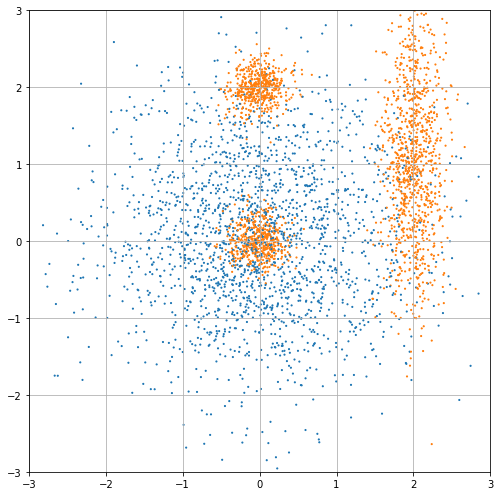

In [11]:
anim_fig = plt.figure(figsize=(7, 7), tight_layout=True)


# anim_fig.suptitle('Evolución de la recta $w_1 x + w_2 y - w_0 = 0$',  fontsize=11)
anim_ax = anim_fig.add_subplot(autoscale_on=False, xlim=(-3, 3), ylim=(-3, 3))
anim_ax.set_aspect('equal')
anim_ax.grid()
x_x = X[:,0]
x_y = X[:,1]
auto_colors=np.zeros(Y.shape[0])
auto_colors=np.where(Y==0,auto_colors,'C0')
auto_colors=np.where(Y==1,auto_colors,'C1')
anim_ax.scatter(x_x, x_y, c=auto_colors,s=5, marker='.')
plt.show()

In [12]:
# el mapa es un arreglo cuyos componentes representan las neuronas numeradas fila a fila
nRows = 15                                         # cantidad de filas
nCols = 15                                        # cantidad de columnas
# radio de activación
actRatio = 2    
nepoc=200
learningRate = 0.6
# inicialización de pesos [habría que hacerlo entre -0.5 y 0.5?]
som = rng.random((nRows * nCols, NInputs))
#historial de actualizaciones del som
som_history = []

for i in range (nepoc):
    som_history  = som_train (X,som,nCols,nRows,actRatio,learningRate,som_history)

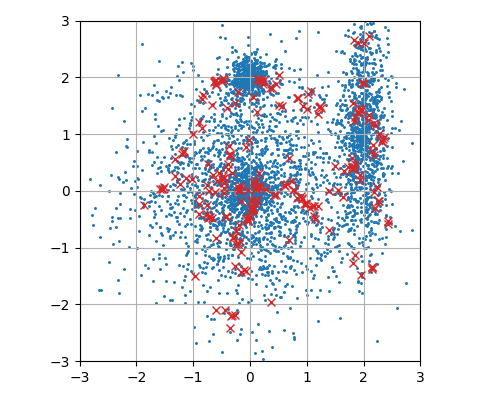

In [13]:
# Animación de la evolución del SOM
import matplotlib.animation as animation
%matplotlib widget

anim_fig = plt.figure(figsize=(5, 4), tight_layout=True)
# anim_fig.suptitle('Evolución de la recta $w_1 x + w_2 y - w_0 = 0$',  fontsize=11)
anim_ax = anim_fig.add_subplot(autoscale_on=False, xlim=(-3, 3), ylim=(-3, 3))
anim_ax.set_aspect('equal')
anim_ax.grid()

# anim_ax.set_xlabel('$X$')
# anim_ax.set_ylabel('$Y$')

# Patrones
x_x = X[:,0]
x_y = X[:,1]
# x_color = np.where(x_x > 0, 'C0', np.where(x_y > 0, 'C0', 'C1'))

anim_ax.scatter(x_x, x_y, c='C0', s=5, marker='.')

points, = anim_ax.plot(som_history[-1][:,0], som_history[-1][:,1], 'x', c='C3')

plt.show()

In [14]:
# radio de activación
actRatio = 1    
nepoc=400
learning_vector = np.arange(0.9,0.1,-(0.8/nepoc))

for i in range (nepoc):
    learningRate=learning_vector[i]
    som_history  = som_train (X,som_history[-1],nCols,nRows,actRatio,learningRate,som_history)

In [15]:
# radio de activación
actRatio = 0    
nepoc=600
learningRate = 1e-3

for i in range (nepoc):
    som_history  = som_train (X,som_history[-1],nCols,nRows,actRatio,learningRate,som_history)

In [18]:
activation_counter = np.zeros((som.shape[0],som.shape[1]))
for pattern,label in zip(X,Y):
    actN = np.argmin(np.linalg.norm(pattern - som_history[-1], 1, axis = 1))
    if(label==0):
        activation_counter[actN][0] += 1 
    else:
        activation_counter[actN][1] += 1

neuron_class=np.zeros(som.shape[0])
for i in range(som.shape[0]):
    neuron_class[i]=1 if (activation_counter[i][1]>activation_counter[i][0]) else 0

In [19]:
y_tst=np.zeros(Y.shape[0])
error_rate=0
for i,(pattern,yd_tst) in enumerate(zip(X,Y)):
    actN = np.argmin(np.linalg.norm(pattern - som_history[-1], 1, axis = 1))
    y_tst[i] = neuron_class[actN]
    if (neuron_class[actN]!=Y[i]):
        error_rate +=1
print(error_rate)

437


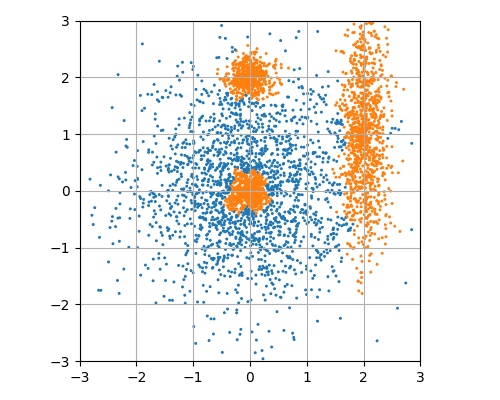

In [20]:
anim_fig = plt.figure(figsize=(5, 4), tight_layout=True)
# anim_fig.suptitle('Evolución de la recta $w_1 x + w_2 y - w_0 = 0$',  fontsize=11)
anim_ax = anim_fig.add_subplot(autoscale_on=False, xlim=(-3, 3), ylim=(-3, 3))
anim_ax.set_aspect('equal')
anim_ax.grid()
x_x = X[:,0]
x_y = X[:,1]
auto_colors=np.zeros(y_tst.shape[0])
auto_colors=np.where(y_tst==0,auto_colors,'C0')
auto_colors=np.where(y_tst==1,auto_colors,'C1')
anim_ax.scatter(x_x, x_y, c=auto_colors,s=5, marker='.')
plt.show()

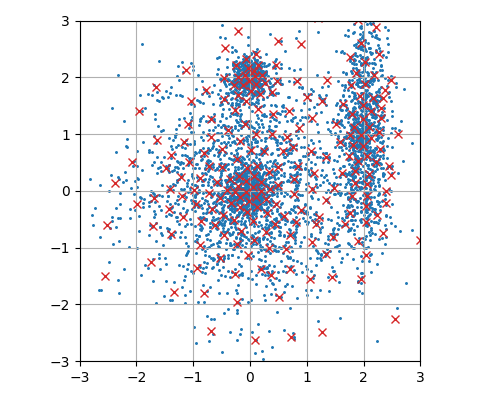

In [22]:
# Animación de la evolución del SOM
import matplotlib.animation as animation
%matplotlib widget

anim_fig = plt.figure(figsize=(5, 4), tight_layout=True)
# anim_fig.suptitle('Evolución de la recta $w_1 x + w_2 y - w_0 = 0$',  fontsize=11)
anim_ax = anim_fig.add_subplot(autoscale_on=False, xlim=(-3, 3), ylim=(-3, 3))
anim_ax.set_aspect('equal')
anim_ax.grid()


# Patrones
x_x = X[:,0]
x_y = X[:,1]


anim_ax.scatter(x_x, x_y, c='C0', s=5, marker='.')

points, = anim_ax.plot(som_history[-1][:,0], som_history[-1][:,1], 'x', c='C3')
plt.show()